# 🧱 DCGAN - Bricks Data

In this notebook, we'll walk through the steps required to train your own DCGAN on the bricks dataset

In [1]:
# Run these lines in Colab
!git clone https://github.com/mxagar/generative_ai_book.git
!mkdir notebooks
!mkdir chekpoint
!mkdir data
!mkdir output
!mkdir models
!mv generative_ai_book/notebooks/utils.py ./notebooks/utils.py
!mv generative_ai_book/notebooks/03_vae/03_vae_faces/vae_utils.py ./notebooks/vae_utils.py
!pip install python-dotenv

Cloning into 'generative_ai_book'...
remote: Enumerating objects: 749, done.
remote: Counting objects: 100% (291/291), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 749 (delta 190), reused 156 (delta 139), pack-reused 458 (from 1)
Receiving objects: 100% (749/749), 49.56 MiB | 21.33 MiB/s, done.
Resolving deltas: 100% (425/425), done.


In [2]:
from dotenv import load_dotenv
import os

# Load environment variables from the .env file
load_dotenv()

# Set an environment variable
# Get values from ./scripts/download.sh
# E.g., celebrity faces dataset: jessicali9530 celeba-dataset
os.environ['KAGGLE_DATASET_USER'] = 'joosthazelzet'
os.environ['KAGGLE_DATASET'] = 'lego-brick-images'

In [3]:
import os
os.system("cd data/ && kaggle datasets download -d $KAGGLE_DATASET_USER/$KAGGLE_DATASET")
!unzip -q -o data/$KAGGLE_DATASET.zip -d data/$KAGGLE_DATASET
!rm data/$KAGGLE_DATASET.zip

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

from notebooks.utils import display, sample_batch

## 0. Parameters <a name="parameters"></a>

In [5]:
IMAGE_SIZE = 64
CHANNELS = 1
BATCH_SIZE = 128
Z_DIM = 100
EPOCHS = 300
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
LEARNING_RATE = 0.0002
NOISE_PARAM = 0.1

## 1. Prepare the data <a name="prepare"></a>

In [6]:
train_data = utils.image_dataset_from_directory(
    "./data/lego-brick-images/dataset/",
    labels=None,
    color_mode="grayscale",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 40000 files.


In [7]:
def preprocess(img):
    """
    Normalize and reshape the images
    """
    img = (tf.cast(img, "float32") - 127.5) / 127.5
    return img


train = train_data.map(lambda x: preprocess(x))

In [8]:
train_sample = sample_batch(train)

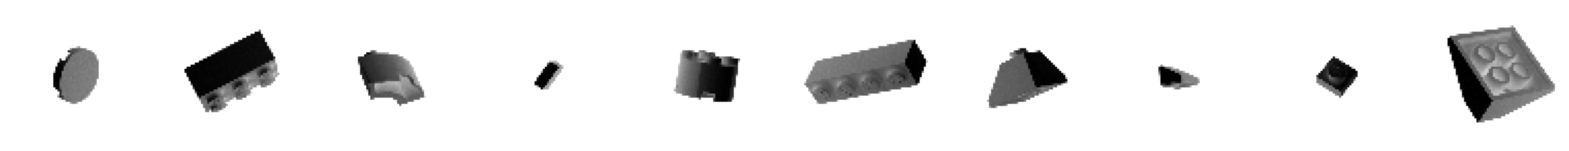

In [9]:
display(train_sample)

## 2. Build the GAN <a name="build"></a>

In [10]:
discriminator_input = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same", use_bias=False)(
    discriminator_input
)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    512, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)
x = layers.Conv2D(
    1,
    kernel_size=4,
    strides=1,
    padding="valid",
    use_bias=False,
    activation="sigmoid",
)(x)
discriminator_output = layers.Flatten()(x)

discriminator = models.Model(discriminator_input, discriminator_output)
discriminator.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 64, 64, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 8, 8, 256)           │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 4, 4, 512)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 1, 1, 1)             │           8,192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,765,312 (10.55 MB)

 Trainable params: 2,763,520 (10.54 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [11]:
generator_input = layers.Input(shape=(Z_DIM,))
x = layers.Reshape((1, 1, Z_DIM))(generator_input)
x = layers.Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = layers.BatchNormalization(momentum=0.9)(x)
x = layers.LeakyReLU(0.2)(x)
generator_output = layers.Conv2DTranspose(
    CHANNELS,
    kernel_size=4,
    strides=2,
    padding="same",
    use_bias=False,
    activation="tanh",
)(x)
generator = models.Model(generator_input, generator_output)
generator.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 1, 1, 100)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 4, 4, 512)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 4, 512)           │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 4, 4, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 8, 8, 256)           │       2,097,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 16, 16, 128)         │         524,288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 32, 32, 64)          │         131,072 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 64, 64, 1)           │           1,024 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,576,576 (13.64 MB)

 Trainable params: 3,574,656 (13.64 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [12]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + NOISE_PARAM * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - NOISE_PARAM * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [13]:
# Create a DCGAN
dcgan = DCGAN(
    discriminator=discriminator, generator=generator, latent_dim=Z_DIM
)

In [14]:
if LOAD_MODEL:
    dcgan.load_weights("./checkpoint/checkpoint.weights.h5")

## 3. Train the GAN <a name="train"></a>

In [15]:
dcgan.compile(
    d_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [16]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.weights.h5",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

Epoch 1/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - d_acc: 0.8340 - d_fake_acc: 0.8321 - d_loss: 0.2728 - d_real_acc: 0.8360 - g_acc: 0.1679 - g_loss: 4.1492
Saved to ./output/generated_img_000.png


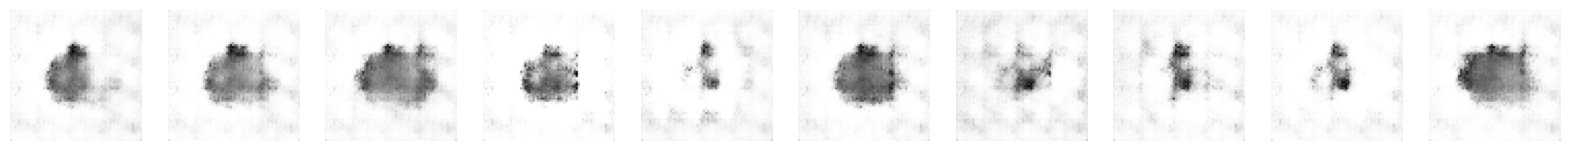

313/313 ━━━━━━━━━━━━━━━━━━━━ 113s 280ms/step - d_acc: 0.8340 - d_fake_acc: 0.8321 - d_loss: 0.2728 - d_real_acc: 0.8359 - g_acc: 0.1679 - g_loss: 4.1481
Epoch 2/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - d_acc: 0.8924 - d_fake_acc: 0.8981 - d_loss: 0.0773 - d_real_acc: 0.8868 - g_acc: 0.1019 - g_loss: 4.2705
Saved to ./output/generated_img_001.png


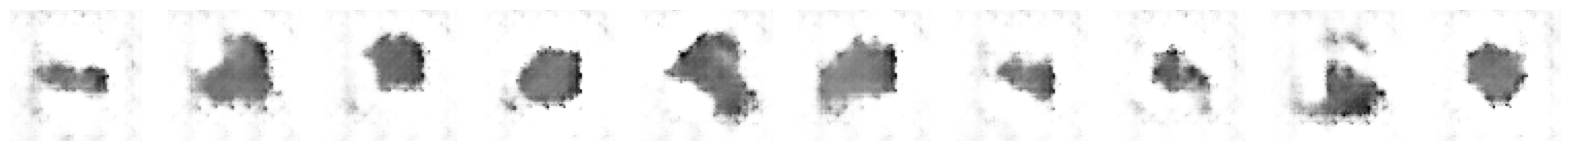

313/313 ━━━━━━━━━━━━━━━━━━━━ 110s 241ms/step - d_acc: 0.8924 - d_fake_acc: 0.8981 - d_loss: 0.0774 - d_real_acc: 0.8867 - g_acc: 0.1019 - g_loss: 4.2714
Epoch 3/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - d_acc: 0.8670 - d_fake_acc: 0.8679 - d_loss: 0.1447 - d_real_acc: 0.8660 - g_acc: 0.1321 - g_loss: 4.4002
Saved to ./output/generated_img_002.png


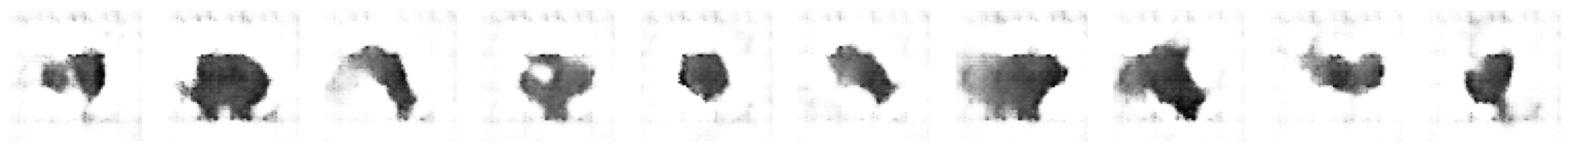

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 240ms/step - d_acc: 0.8670 - d_fake_acc: 0.8680 - d_loss: 0.1447 - d_real_acc: 0.8660 - g_acc: 0.1320 - g_loss: 4.3999
Epoch 4/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - d_acc: 0.8429 - d_fake_acc: 0.8404 - d_loss: 0.2840 - d_real_acc: 0.8454 - g_acc: 0.1596 - g_loss: 3.6152
Saved to ./output/generated_img_003.png


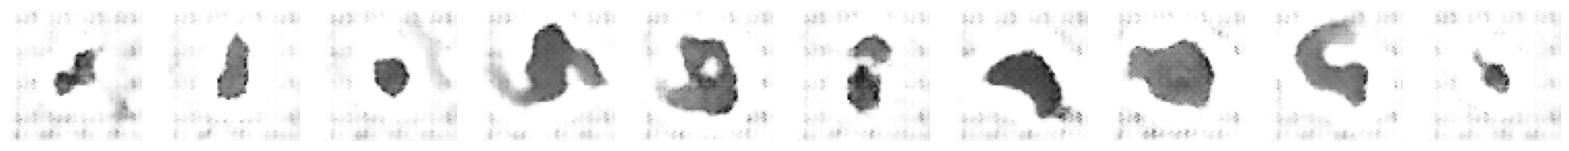

313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - d_acc: 0.8429 - d_fake_acc: 0.8404 - d_loss: 0.2838 - d_real_acc: 0.8454 - g_acc: 0.1596 - g_loss: 3.6149
Epoch 5/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - d_acc: 0.8450 - d_fake_acc: 0.8443 - d_loss: 0.2218 - d_real_acc: 0.8456 - g_acc: 0.1557 - g_loss: 3.5060
Saved to ./output/generated_img_004.png


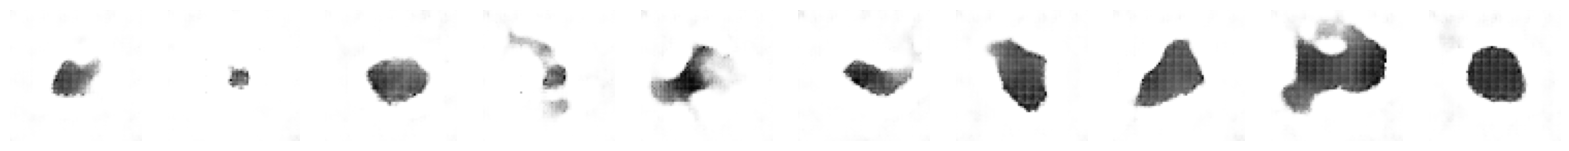

313/313 ━━━━━━━━━━━━━━━━━━━━ 76s 244ms/step - d_acc: 0.8450 - d_fake_acc: 0.8444 - d_loss: 0.2217 - d_real_acc: 0.8456 - g_acc: 0.1556 - g_loss: 3.5060
Epoch 6/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - d_acc: 0.8828 - d_fake_acc: 0.8818 - d_loss: 0.1401 - d_real_acc: 0.8837 - g_acc: 0.1182 - g_loss: 3.6832
Saved to ./output/generated_img_005.png


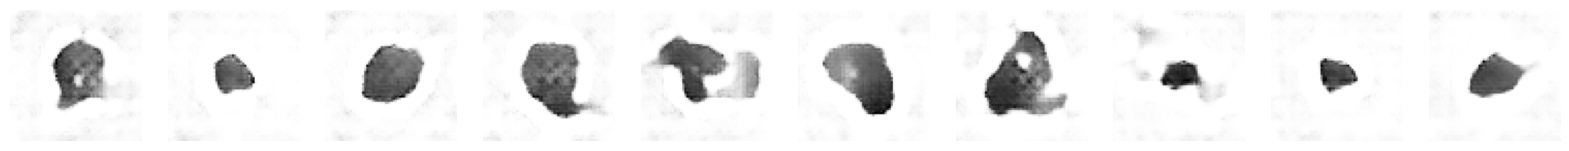

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 247ms/step - d_acc: 0.8828 - d_fake_acc: 0.8818 - d_loss: 0.1401 - d_real_acc: 0.8837 - g_acc: 0.1182 - g_loss: 3.6832
Epoch 7/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - d_acc: 0.8867 - d_fake_acc: 0.8866 - d_loss: 0.1286 - d_real_acc: 0.8869 - g_acc: 0.1134 - g_loss: 3.6959
Saved to ./output/generated_img_006.png


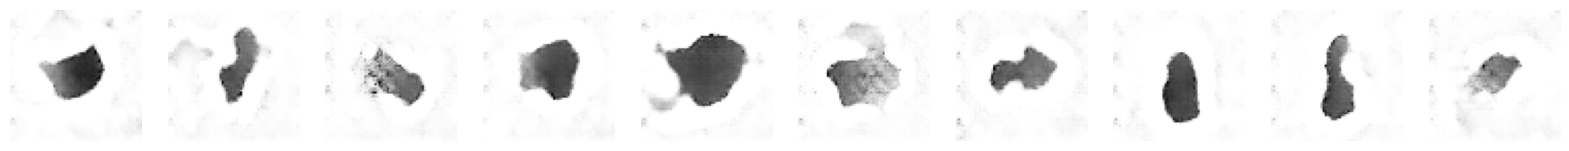

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 246ms/step - d_acc: 0.8867 - d_fake_acc: 0.8866 - d_loss: 0.1286 - d_real_acc: 0.8869 - g_acc: 0.1134 - g_loss: 3.6961
Epoch 8/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - d_acc: 0.8825 - d_fake_acc: 0.8780 - d_loss: 0.1337 - d_real_acc: 0.8869 - g_acc: 0.1220 - g_loss: 3.9361
Saved to ./output/generated_img_007.png


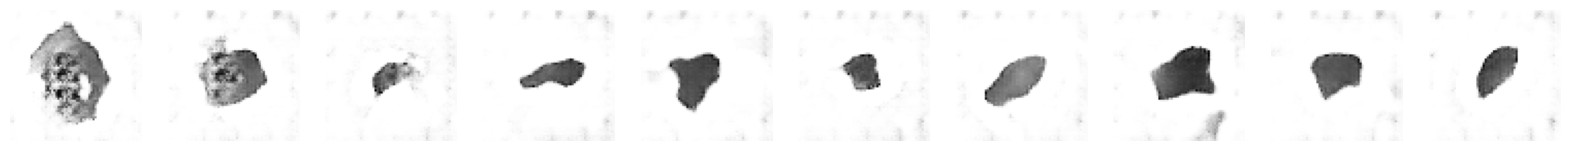

313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 248ms/step - d_acc: 0.8825 - d_fake_acc: 0.8781 - d_loss: 0.1337 - d_real_acc: 0.8869 - g_acc: 0.1219 - g_loss: 3.9361
Epoch 9/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - d_acc: 0.8803 - d_fake_acc: 0.8850 - d_loss: 0.1083 - d_real_acc: 0.8757 - g_acc: 0.1150 - g_loss: 4.1542
Saved to ./output/generated_img_008.png


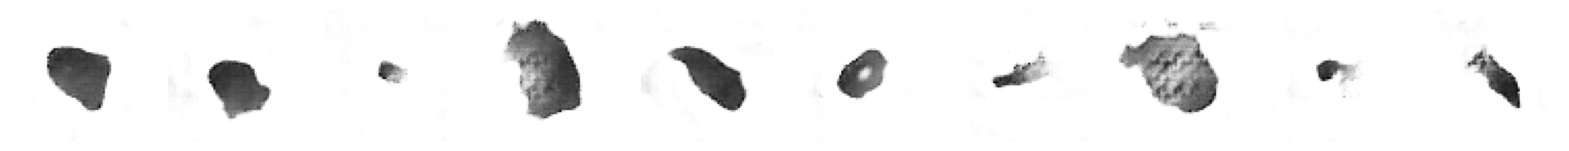

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 247ms/step - d_acc: 0.8803 - d_fake_acc: 0.8850 - d_loss: 0.1083 - d_real_acc: 0.8757 - g_acc: 0.1150 - g_loss: 4.1543
Epoch 10/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - d_acc: 0.8991 - d_fake_acc: 0.8996 - d_loss: 0.0771 - d_real_acc: 0.8986 - g_acc: 0.1004 - g_loss: 4.2674
Saved to ./output/generated_img_009.png


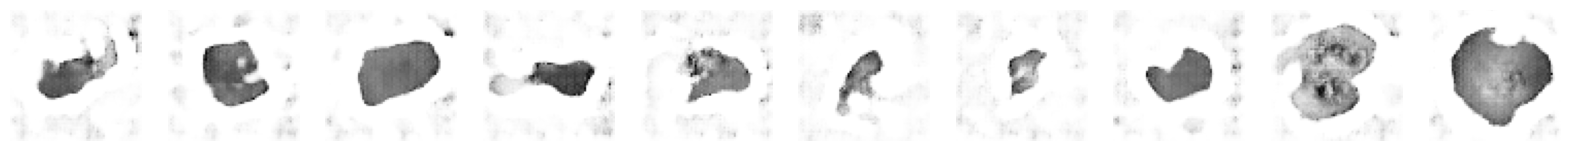

313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 249ms/step - d_acc: 0.8991 - d_fake_acc: 0.8996 - d_loss: 0.0771 - d_real_acc: 0.8986 - g_acc: 0.1004 - g_loss: 4.2674
Epoch 11/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step - d_acc: 0.8842 - d_fake_acc: 0.8838 - d_loss: 0.1161 - d_real_acc: 0.8846 - g_acc: 0.1162 - g_loss: 4.2938
Saved to ./output/generated_img_010.png


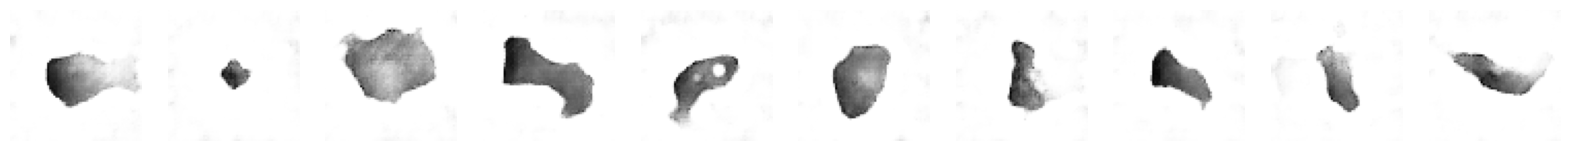

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 250ms/step - d_acc: 0.8842 - d_fake_acc: 0.8838 - d_loss: 0.1160 - d_real_acc: 0.8846 - g_acc: 0.1162 - g_loss: 4.2939
Epoch 12/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - d_acc: 0.8924 - d_fake_acc: 0.8930 - d_loss: 0.1084 - d_real_acc: 0.8918 - g_acc: 0.1070 - g_loss: 4.3845
Saved to ./output/generated_img_011.png


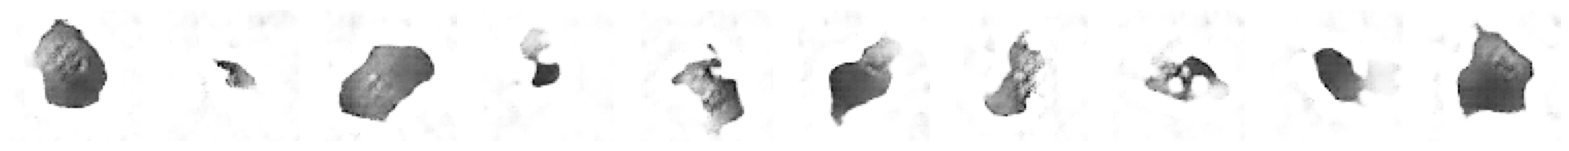

313/313 ━━━━━━━━━━━━━━━━━━━━ 78s 249ms/step - d_acc: 0.8924 - d_fake_acc: 0.8931 - d_loss: 0.1082 - d_real_acc: 0.8918 - g_acc: 0.1069 - g_loss: 4.3851
Epoch 13/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - d_acc: 0.8918 - d_fake_acc: 0.8950 - d_loss: 0.0882 - d_real_acc: 0.8886 - g_acc: 0.1050 - g_loss: 4.7175
Saved to ./output/generated_img_012.png


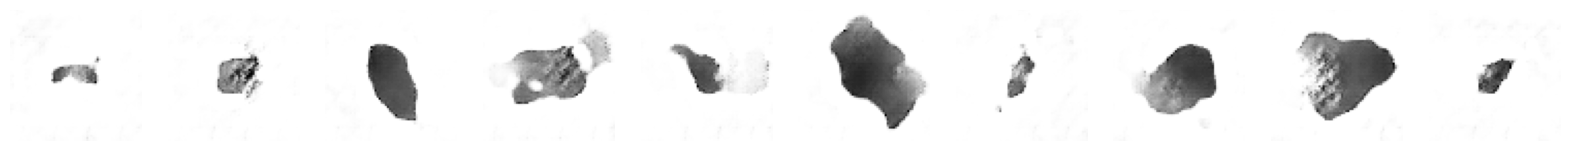

313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 252ms/step - d_acc: 0.8919 - d_fake_acc: 0.8951 - d_loss: 0.0881 - d_real_acc: 0.8887 - g_acc: 0.1049 - g_loss: 4.7172
Epoch 14/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - d_acc: 0.9280 - d_fake_acc: 0.9290 - d_loss: -0.0111 - d_real_acc: 0.9271 - g_acc: 0.0710 - g_loss: 5.2352
Saved to ./output/generated_img_013.png


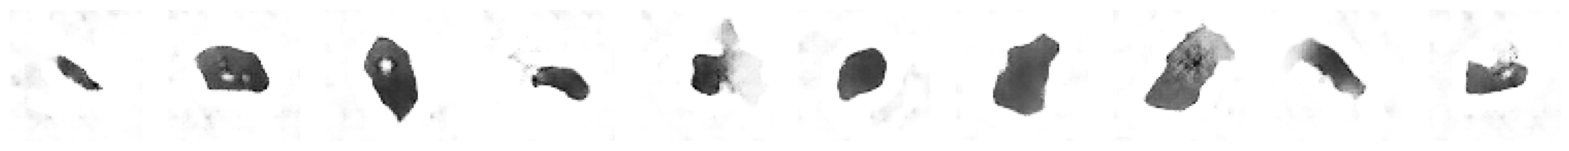

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 251ms/step - d_acc: 0.9280 - d_fake_acc: 0.9289 - d_loss: -0.0109 - d_real_acc: 0.9270 - g_acc: 0.0711 - g_loss: 5.2343
Epoch 15/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - d_acc: 0.9303 - d_fake_acc: 0.9307 - d_loss: -7.4695e-04 - d_real_acc: 0.9299 - g_acc: 0.0693 - g_loss: 4.8927
Saved to ./output/generated_img_014.png


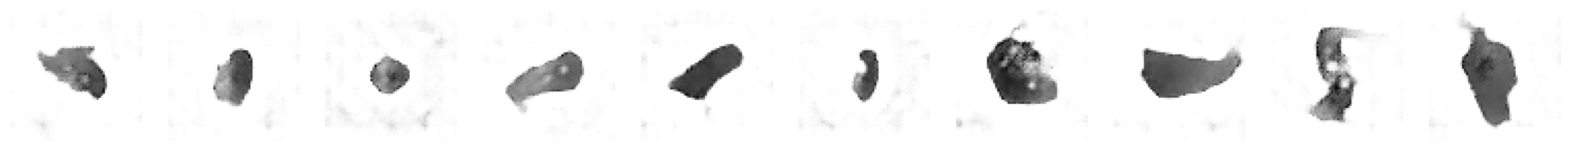

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step - d_acc: 0.9302 - d_fake_acc: 0.9306 - d_loss: -4.2597e-04 - d_real_acc: 0.9298 - g_acc: 0.0694 - g_loss: 4.8919
Epoch 16/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - d_acc: 0.9048 - d_fake_acc: 0.9066 - d_loss: 0.0527 - d_real_acc: 0.9031 - g_acc: 0.0934 - g_loss: 4.8523
Saved to ./output/generated_img_015.png


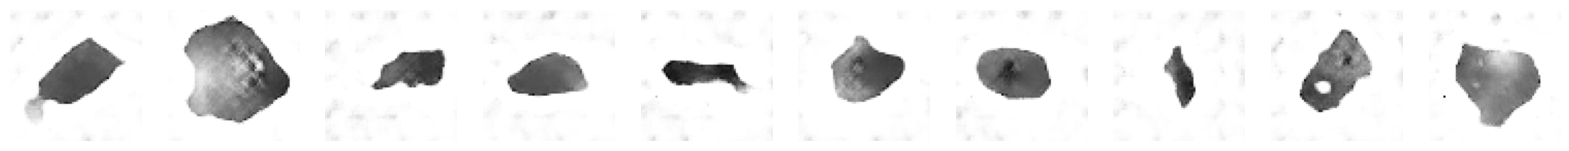

313/313 ━━━━━━━━━━━━━━━━━━━━ 79s 254ms/step - d_acc: 0.9049 - d_fake_acc: 0.9066 - d_loss: 0.0525 - d_real_acc: 0.9032 - g_acc: 0.0934 - g_loss: 4.8530
Epoch 17/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - d_acc: 0.9399 - d_fake_acc: 0.9420 - d_loss: -0.0618 - d_real_acc: 0.9377 - g_acc: 0.0580 - g_loss: 5.6048
Saved to ./output/generated_img_016.png


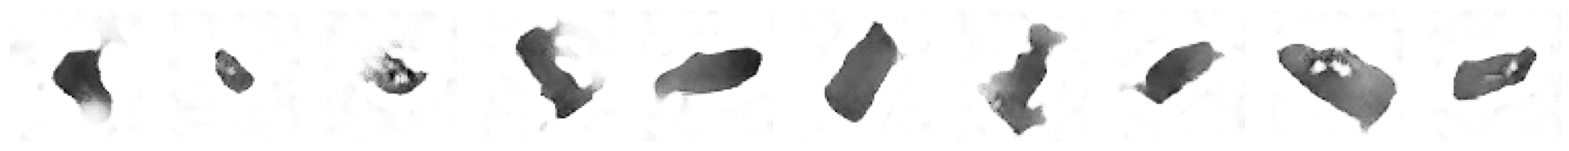

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 254ms/step - d_acc: 0.9399 - d_fake_acc: 0.9420 - d_loss: -0.0617 - d_real_acc: 0.9377 - g_acc: 0.0580 - g_loss: 5.6045
Epoch 18/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - d_acc: 0.9552 - d_fake_acc: 0.9565 - d_loss: -0.1083 - d_real_acc: 0.9539 - g_acc: 0.0435 - g_loss: 5.8341
Saved to ./output/generated_img_017.png


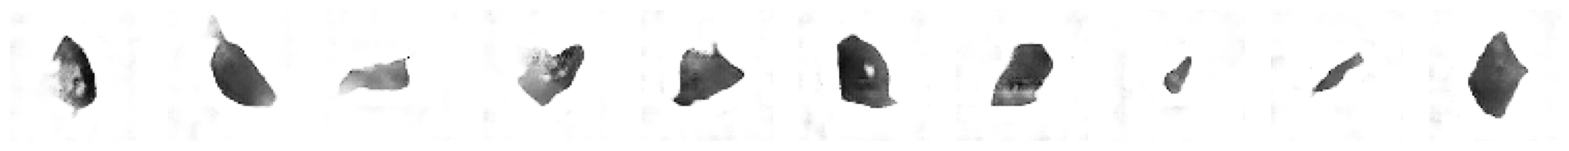

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 253ms/step - d_acc: 0.9552 - d_fake_acc: 0.9565 - d_loss: -0.1084 - d_real_acc: 0.9539 - g_acc: 0.0435 - g_loss: 5.8347
Epoch 19/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - d_acc: 0.9180 - d_fake_acc: 0.9197 - d_loss: -0.0017 - d_real_acc: 0.9164 - g_acc: 0.0803 - g_loss: 6.2084
Saved to ./output/generated_img_018.png


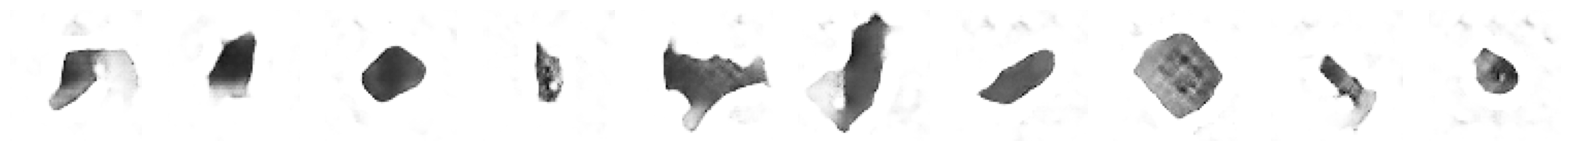

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 254ms/step - d_acc: 0.9180 - d_fake_acc: 0.9197 - d_loss: -0.0018 - d_real_acc: 0.9164 - g_acc: 0.0803 - g_loss: 6.2072
Epoch 20/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - d_acc: 0.9500 - d_fake_acc: 0.9486 - d_loss: -0.1182 - d_real_acc: 0.9514 - g_acc: 0.0514 - g_loss: 6.0600
Saved to ./output/generated_img_019.png


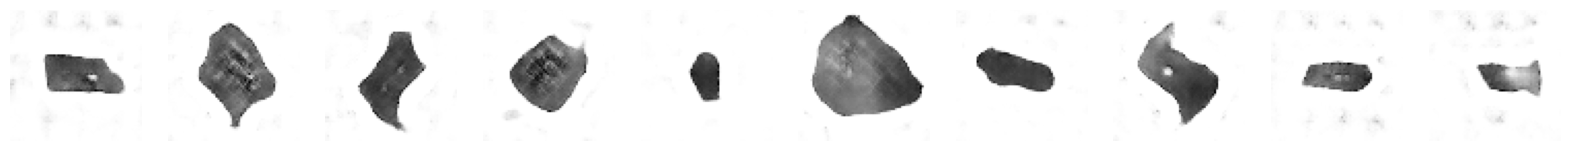

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 256ms/step - d_acc: 0.9499 - d_fake_acc: 0.9486 - d_loss: -0.1180 - d_real_acc: 0.9513 - g_acc: 0.0514 - g_loss: 6.0596
Epoch 21/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - d_acc: 0.9437 - d_fake_acc: 0.9448 - d_loss: -0.0744 - d_real_acc: 0.9425 - g_acc: 0.0552 - g_loss: 5.9973
Saved to ./output/generated_img_020.png


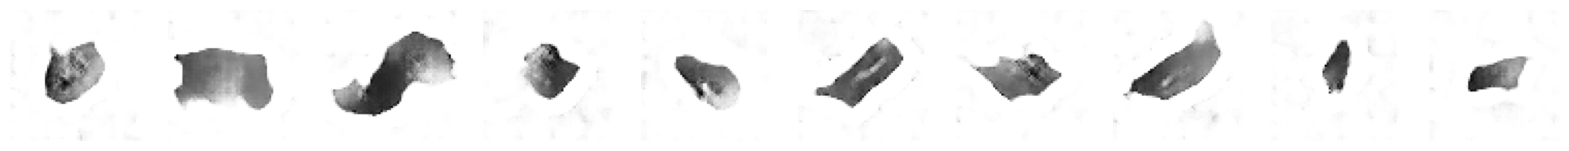

313/313 ━━━━━━━━━━━━━━━━━━━━ 81s 253ms/step - d_acc: 0.9436 - d_fake_acc: 0.9448 - d_loss: -0.0743 - d_real_acc: 0.9425 - g_acc: 0.0552 - g_loss: 5.9968
Epoch 22/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step - d_acc: 0.9398 - d_fake_acc: 0.9404 - d_loss: -0.0764 - d_real_acc: 0.9392 - g_acc: 0.0596 - g_loss: 6.7771
Saved to ./output/generated_img_021.png


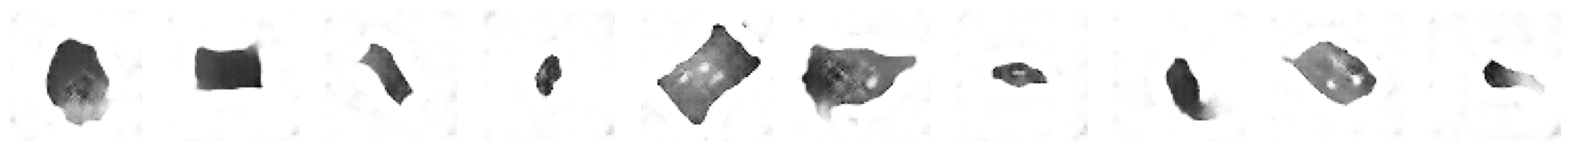

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 256ms/step - d_acc: 0.9398 - d_fake_acc: 0.9404 - d_loss: -0.0765 - d_real_acc: 0.9392 - g_acc: 0.0596 - g_loss: 6.7770
Epoch 23/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - d_acc: 0.9299 - d_fake_acc: 0.9283 - d_loss: -0.0503 - d_real_acc: 0.9315 - g_acc: 0.0717 - g_loss: 6.6911
Saved to ./output/generated_img_022.png


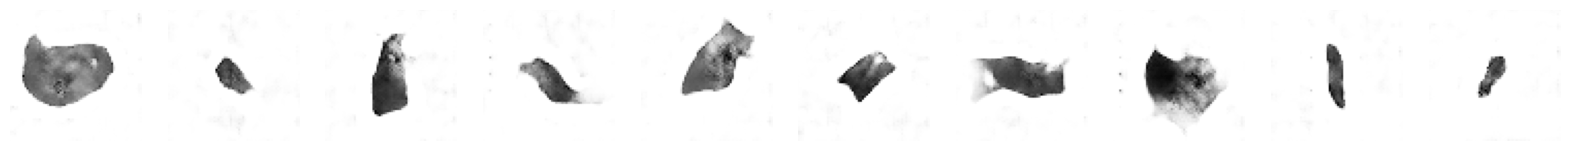

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 258ms/step - d_acc: 0.9299 - d_fake_acc: 0.9283 - d_loss: -0.0503 - d_real_acc: 0.9315 - g_acc: 0.0717 - g_loss: 6.6907
Epoch 24/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - d_acc: 0.9211 - d_fake_acc: 0.9210 - d_loss: 0.0399 - d_real_acc: 0.9211 - g_acc: 0.0790 - g_loss: 6.0840
Saved to ./output/generated_img_023.png


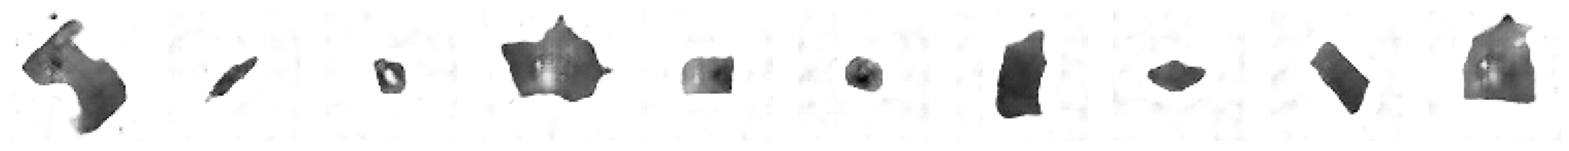

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 260ms/step - d_acc: 0.9211 - d_fake_acc: 0.9210 - d_loss: 0.0398 - d_real_acc: 0.9211 - g_acc: 0.0790 - g_loss: 6.0845
Epoch 25/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - d_acc: 0.9419 - d_fake_acc: 0.9399 - d_loss: -0.1066 - d_real_acc: 0.9440 - g_acc: 0.0601 - g_loss: 6.5652
Saved to ./output/generated_img_024.png


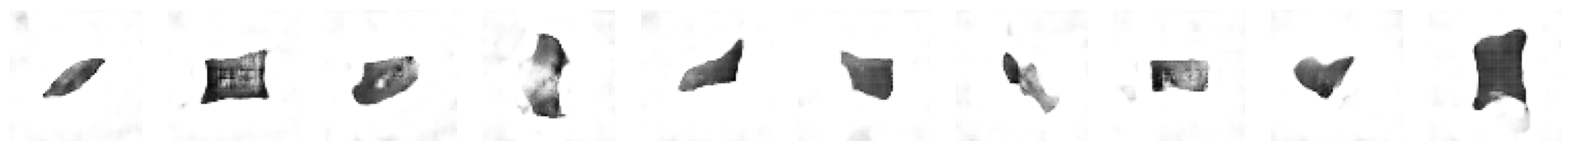

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - d_acc: 0.9420 - d_fake_acc: 0.9399 - d_loss: -0.1067 - d_real_acc: 0.9440 - g_acc: 0.0601 - g_loss: 6.5668
Epoch 26/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - d_acc: 0.9316 - d_fake_acc: 0.9327 - d_loss: -0.0684 - d_real_acc: 0.9305 - g_acc: 0.0673 - g_loss: 6.5486
Saved to ./output/generated_img_025.png


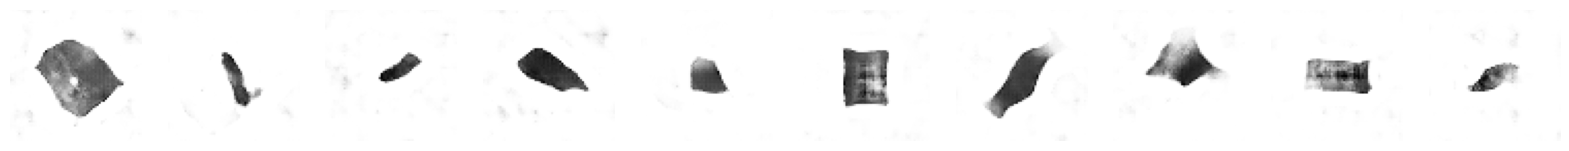

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - d_acc: 0.9316 - d_fake_acc: 0.9327 - d_loss: -0.0685 - d_real_acc: 0.9305 - g_acc: 0.0673 - g_loss: 6.5497
Epoch 27/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - d_acc: 0.9489 - d_fake_acc: 0.9487 - d_loss: -0.1743 - d_real_acc: 0.9490 - g_acc: 0.0513 - g_loss: 7.5381
Saved to ./output/generated_img_026.png


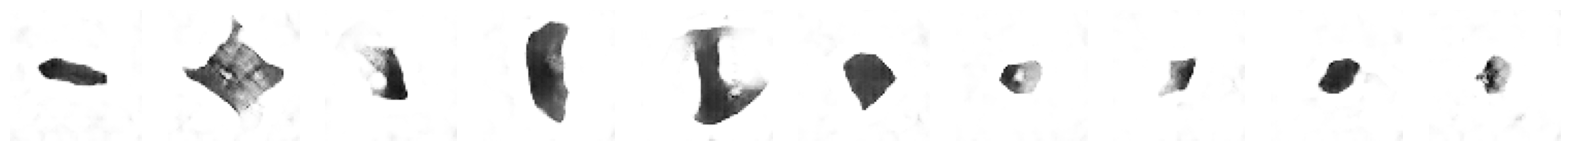

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - d_acc: 0.9488 - d_fake_acc: 0.9487 - d_loss: -0.1740 - d_real_acc: 0.9490 - g_acc: 0.0513 - g_loss: 7.5368
Epoch 28/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - d_acc: 0.9340 - d_fake_acc: 0.9355 - d_loss: -0.0906 - d_real_acc: 0.9325 - g_acc: 0.0645 - g_loss: 7.1952
Saved to ./output/generated_img_027.png


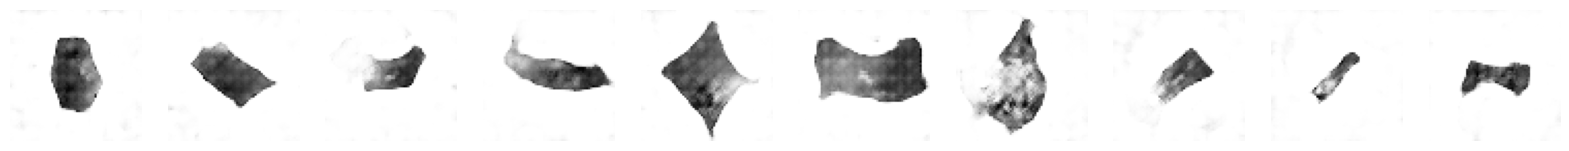

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 260ms/step - d_acc: 0.9340 - d_fake_acc: 0.9355 - d_loss: -0.0906 - d_real_acc: 0.9325 - g_acc: 0.0645 - g_loss: 7.1956
Epoch 29/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - d_acc: 0.9635 - d_fake_acc: 0.9637 - d_loss: -0.2410 - d_real_acc: 0.9632 - g_acc: 0.0363 - g_loss: 7.5897
Saved to ./output/generated_img_028.png


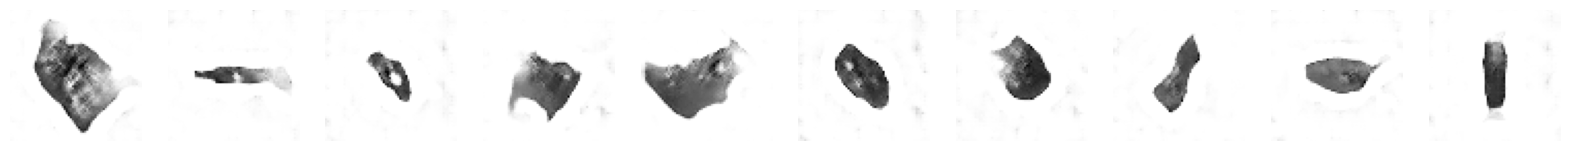

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 259ms/step - d_acc: 0.9634 - d_fake_acc: 0.9637 - d_loss: -0.2409 - d_real_acc: 0.9632 - g_acc: 0.0363 - g_loss: 7.5909
Epoch 30/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step - d_acc: 0.9238 - d_fake_acc: 0.9406 - d_loss: 0.1237 - d_real_acc: 0.9069 - g_acc: 0.0594 - g_loss: 7.9444
Saved to ./output/generated_img_029.png


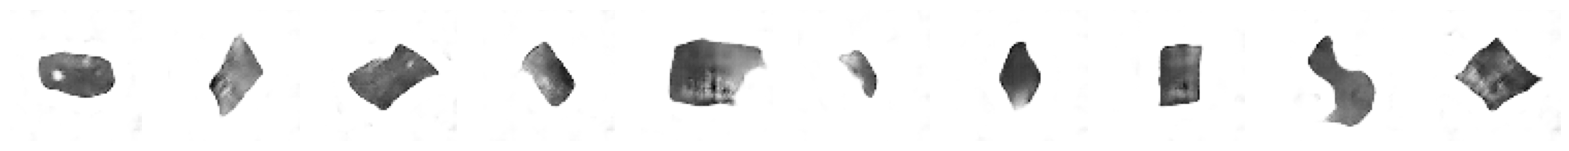

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 261ms/step - d_acc: 0.9237 - d_fake_acc: 0.9405 - d_loss: 0.1241 - d_real_acc: 0.9069 - g_acc: 0.0595 - g_loss: 7.9433
Epoch 31/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - d_acc: 0.9601 - d_fake_acc: 0.9647 - d_loss: -0.1861 - d_real_acc: 0.9555 - g_acc: 0.0353 - g_loss: 8.3838
Saved to ./output/generated_img_030.png


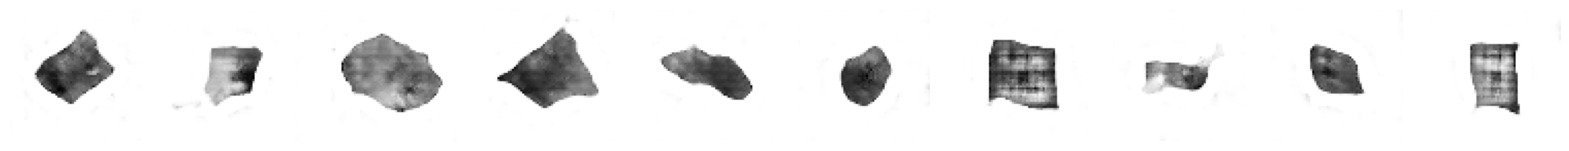

313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 262ms/step - d_acc: 0.9600 - d_fake_acc: 0.9646 - d_loss: -0.1856 - d_real_acc: 0.9554 - g_acc: 0.0354 - g_loss: 8.3832
Epoch 32/300
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - d_acc: 0.9323 - d_fake_acc: 0.9323 - d_loss: -0.0800 - d_real_acc: 0.9324 - g_acc: 0.0677 - g_loss: 7.2985
Saved to ./output/generated_img_031.png


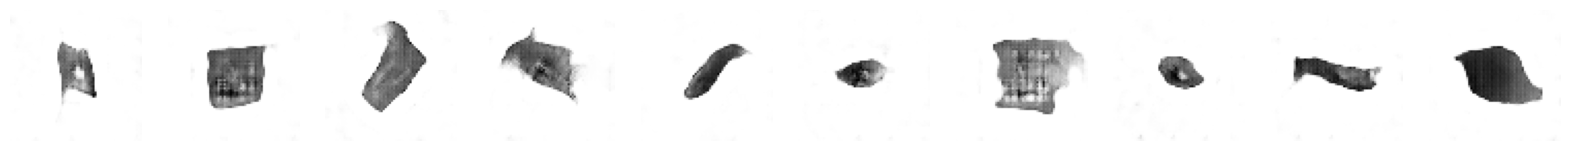

313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 265ms/step - d_acc: 0.9324 - d_fake_acc: 0.9324 - d_loss: -0.0804 - d_real_acc: 0.9324 - g_acc: 0.0676 - g_loss: 7.3009
Epoch 33/300
233/313 ━━━━━━━━━━━━━━━━━━━━ 20s 261ms/step - d_acc: 0.9285 - d_fake_acc: 0.9311 - d_loss: -0.0596 - d_real_acc: 0.9260 - g_acc: 0.0689 - g_loss: 8.0424

KeyboardInterrupt: 

In [17]:
dcgan.fit(
    train,
    epochs=EPOCHS,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [18]:
# Save the final models
generator.save("./models/generator.keras")
discriminator.save("./models/discriminator.keras")

## 3. Generate new images <a name="decode"></a>

In [19]:
# Sample some points in the latent space, from the standard normal distribution
grid_width, grid_height = (10, 3)
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))

In [20]:
# Decode the sampled points
reconstructions = generator.predict(z_sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step


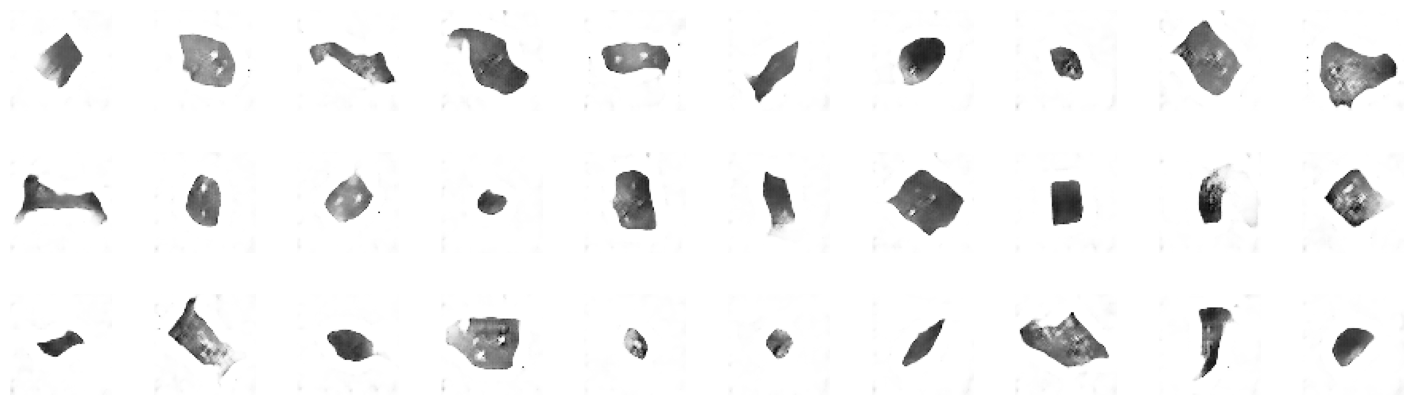

In [21]:
# Draw a plot of decoded images
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Output the grid of faces
for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [22]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [23]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


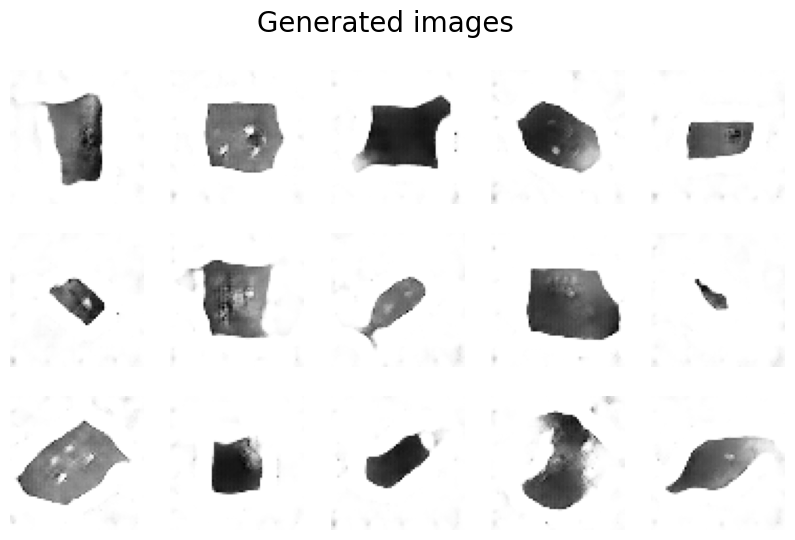

In [24]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, Z_DIM))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

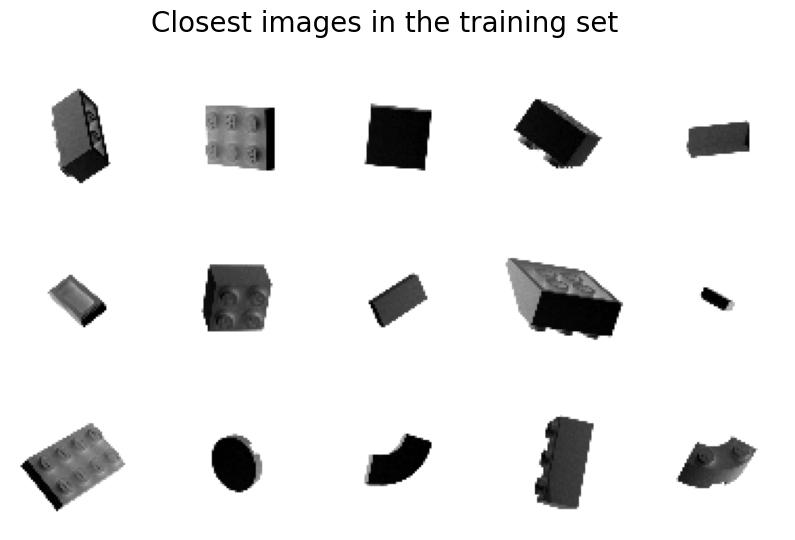

In [25]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()